# Trying to find the correct metric for SOP and AOP

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from utils.utils_analyze import topk_entropy, top12_prob_diff,get_label_rank_practical
from tqdm import tqdm
import seaborn as sns
from utils.config_read import *
sns.set_theme()

def standard_score(tensor):
    mean = tensor.float().mean()
    std = tensor.float().std()
    return (tensor - mean) / std

In [2]:
def get_stats(loaded_data, loaded_label):
    N_sample = len(loaded_data)
    results = {}
    entropy_list = []
    yprob_list = []
    prefix_list = []
    rank_list = []
    for i in tqdm(range(N_sample)):
        logits = loaded_data[i]
        labels = loaded_label[i]
        probs = F.softmax(logits, dim=-1)  # [L, V]
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)  # [L]
        entropy_list.append(entropy)
    
        diff, top1_prob, top2_prob, yprob = top12_prob_diff(logits, labels)
        yprob_list.append(yprob)
        prefix = [torch.tensor([1])]
        for j in range(yprob.shape[0]-1):
            prefix.append(yprob[:j+1].sum() / (j+1))
        prefix_list.append(torch.tensor(prefix))
        
        rank = get_label_rank_practical(logits, labels, max_rank_to_compute=RANK_MAX)
        rank_list.append(rank)
    entropy_all = torch.cat(entropy_list,dim=0)
    yprob_all = torch.cat(yprob_list,dim=0)
    prefix_all = torch.cat(prefix_list,dim=0)
    rank_all = torch.cat(rank_list,dim=0)
    
    results['entropy'] = entropy_all
    results['yprob'] = yprob_all
    results['prefix'] = prefix_all
    results['rank'] = rank_all
    return results

In [5]:
MODEL = "Qwen2.5-Math-1.5B" #"Qwen2.5-Math-7B-Instruct" #config['model']['name'].split('/')[1] #"Qwen2.5-0.5B" #
SCRATCH_PATH = f'/scratch/joshua52/sft_rl_temp/{MODEL}/'
RANK_MAX = 160000
print(f'Model is {MODEL}')

EXP_NAME = 'sft'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

sft_results = get_stats(loaded_data, loaded_label)


EXP_NAME = 'rl_tmp1'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

rl_tmp1_results = get_stats(loaded_data, loaded_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:04<00:00, 13.28s/it]


Text(0, 0.5, 'entropy')

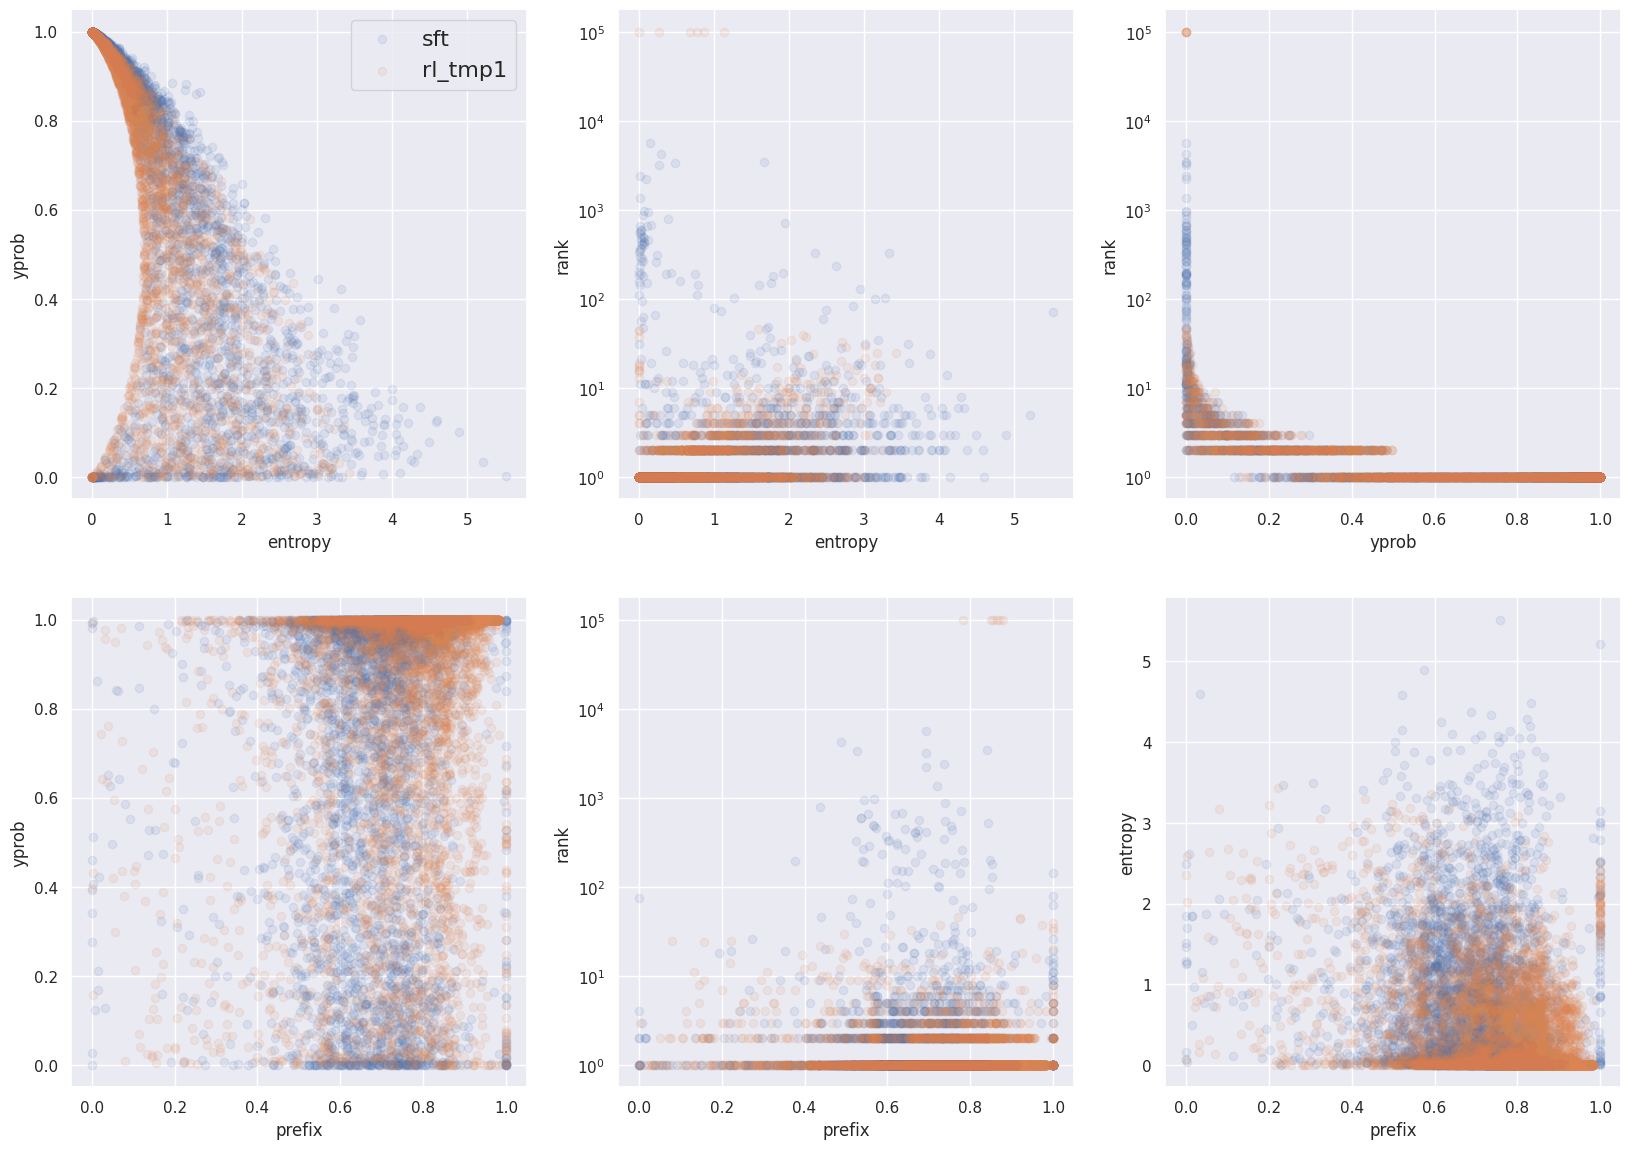

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14))
XY = ('entropy', 'yprob')
ax[0][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1,label='sft')
ax[0][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1,label='rl_tmp1')
ax[0][0].set_xlabel(XY[0])
ax[0][0].set_ylabel(XY[1])
ax[0][0].legend(fontsize=16)

XY = ('entropy', 'rank')
ax[0][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][1].set_xlabel(XY[0])
ax[0][1].set_ylabel(XY[1])
ax[0][1].set_yscale('log')

XY = ('yprob', 'rank')
ax[0][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][2].set_xlabel(XY[0])
ax[0][2].set_ylabel(XY[1])
ax[0][2].set_yscale('log')

XY = ('prefix', 'yprob')
ax[1][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][0].set_xlabel(XY[0])
ax[1][0].set_ylabel(XY[1])

XY = ('prefix', 'rank')
ax[1][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][1].set_xlabel(XY[0])
ax[1][1].set_ylabel(XY[1])
ax[1][1].set_yscale('log')

XY = ('prefix', 'entropy')
ax[1][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][2].set_xlabel(XY[0])
ax[1][2].set_ylabel(XY[1])

In [3]:
MODEL = "Qwen2.5-7B-Instruct" #config['model']['name'].split('/')[1] #"Qwen2.5-0.5B" #
SCRATCH_PATH = f'/scratch/joshua52/sft_rl_temp/{MODEL}/'
RANK_MAX = 160000
print(f'Model is {MODEL}')

EXP_NAME = 'sft'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

sft_results = get_stats(loaded_data, loaded_label)


EXP_NAME = 'rl_tmp1'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

rl_tmp1_results = get_stats(loaded_data, loaded_label)

Model is Qwen2.5-7B-Instruct


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [19:01<00:00, 22.83s/it]


Text(0, 0.5, 'entropy')

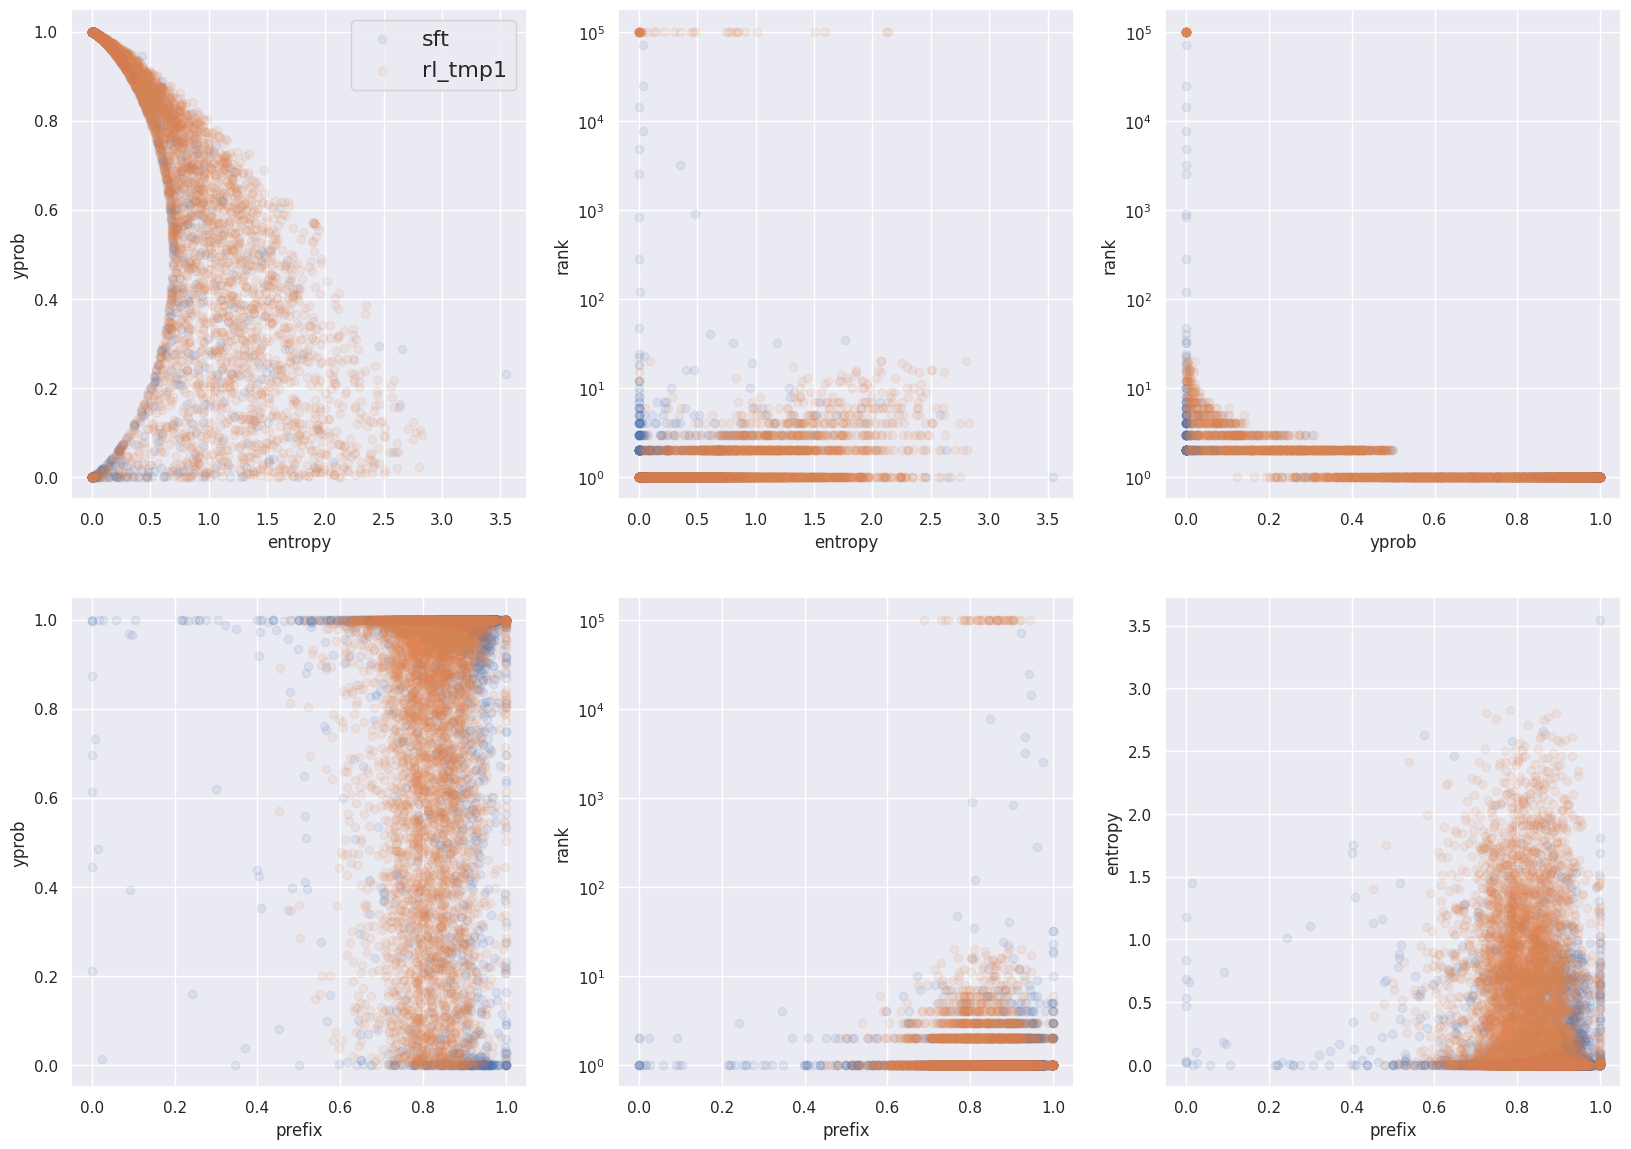

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14))
XY = ('entropy', 'yprob')
ax[0][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1,label='sft')
ax[0][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1,label='rl_tmp1')
ax[0][0].set_xlabel(XY[0])
ax[0][0].set_ylabel(XY[1])
ax[0][0].legend(fontsize=16)

XY = ('entropy', 'rank')
ax[0][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][1].set_xlabel(XY[0])
ax[0][1].set_ylabel(XY[1])
ax[0][1].set_yscale('log')

XY = ('yprob', 'rank')
ax[0][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][2].set_xlabel(XY[0])
ax[0][2].set_ylabel(XY[1])
ax[0][2].set_yscale('log')

XY = ('prefix', 'yprob')
ax[1][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][0].set_xlabel(XY[0])
ax[1][0].set_ylabel(XY[1])

XY = ('prefix', 'rank')
ax[1][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][1].set_xlabel(XY[0])
ax[1][1].set_ylabel(XY[1])
ax[1][1].set_yscale('log')

XY = ('prefix', 'entropy')
ax[1][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][2].set_xlabel(XY[0])
ax[1][2].set_ylabel(XY[1])

In [5]:
MODEL = "Qwen2.5-Math-7B-Instruct" #config['model']['name'].split('/')[1] #"Qwen2.5-0.5B" #
SCRATCH_PATH = f'/scratch/joshua52/sft_rl_temp/{MODEL}/'
RANK_MAX = 160000
print(f'Model is {MODEL}')

EXP_NAME = 'sft'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

sft_results = get_stats(loaded_data, loaded_label)


EXP_NAME = 'rl_tmp1'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

rl_tmp1_results = get_stats(loaded_data, loaded_label)

Model is Qwen2.5-Math-7B-Instruct


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [19:27<00:00, 23.35s/it]


Text(0, 0.5, 'entropy')

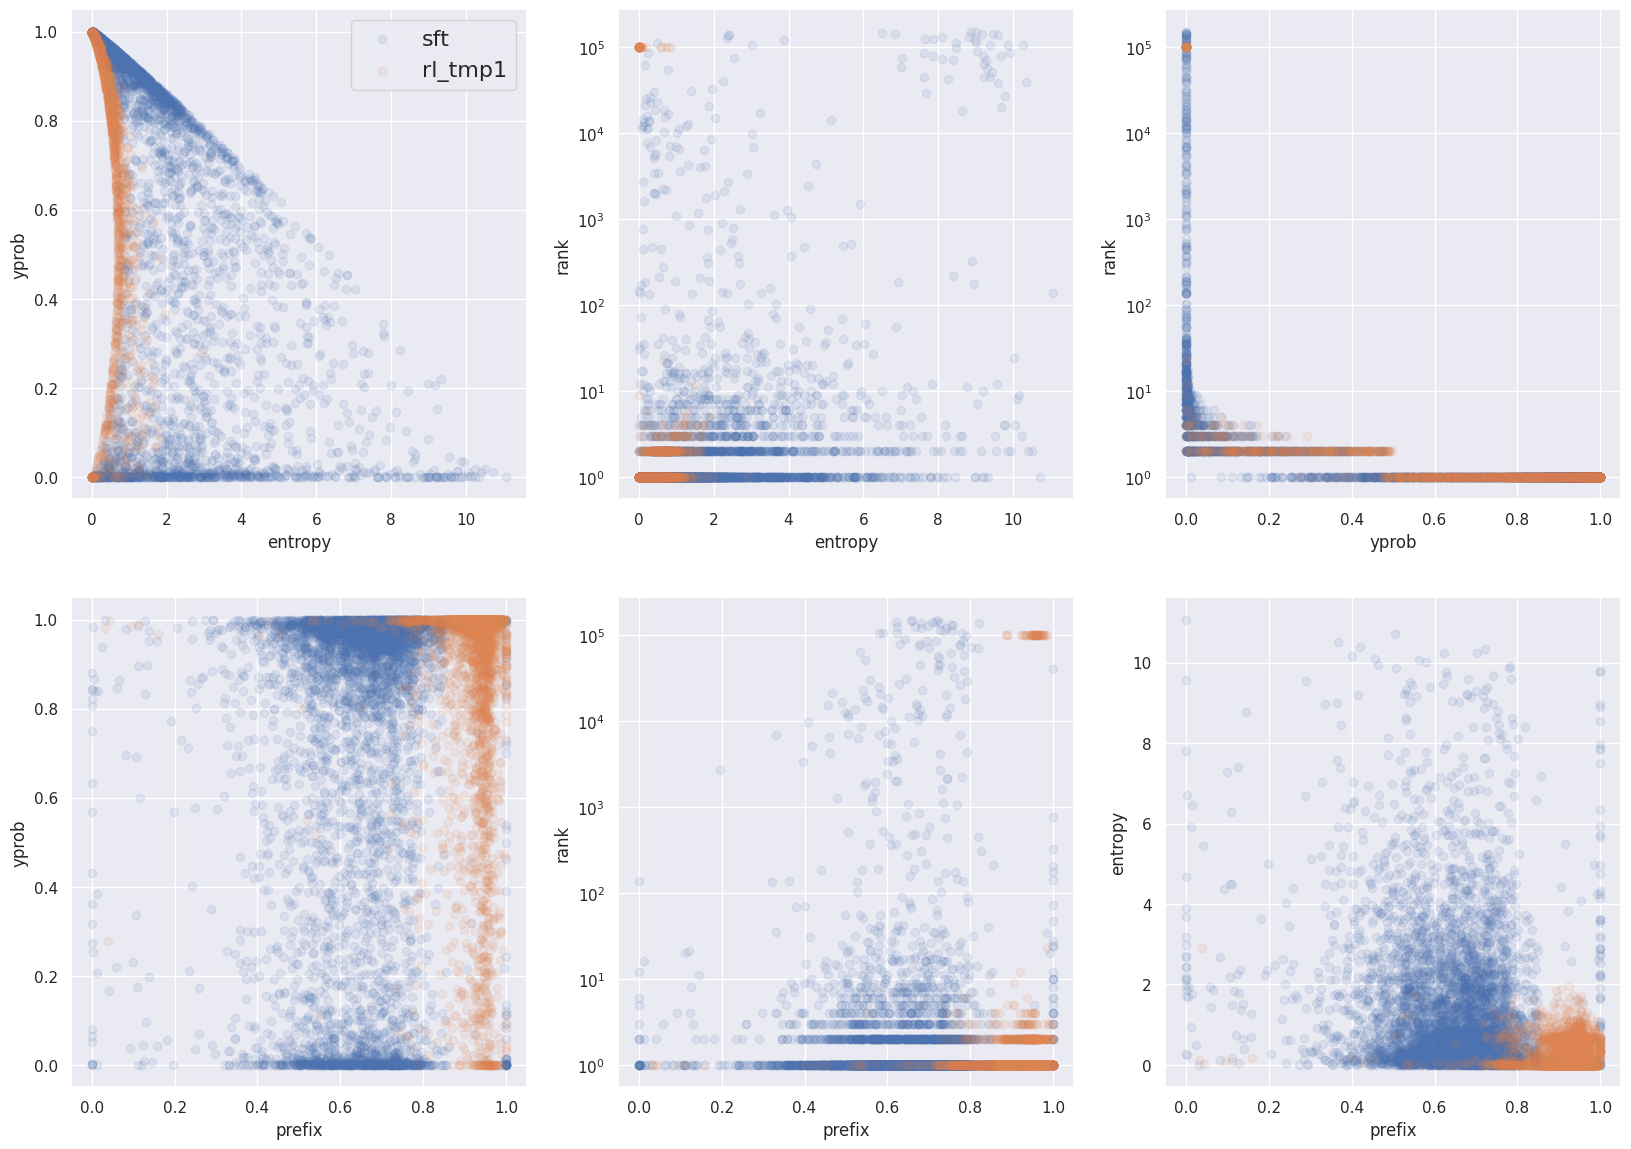

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14))
XY = ('entropy', 'yprob')
ax[0][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1,label='sft')
ax[0][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1,label='rl_tmp1')
ax[0][0].set_xlabel(XY[0])
ax[0][0].set_ylabel(XY[1])
ax[0][0].legend(fontsize=16)

XY = ('entropy', 'rank')
ax[0][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][1].set_xlabel(XY[0])
ax[0][1].set_ylabel(XY[1])
ax[0][1].set_yscale('log')

XY = ('yprob', 'rank')
ax[0][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][2].set_xlabel(XY[0])
ax[0][2].set_ylabel(XY[1])
ax[0][2].set_yscale('log')

XY = ('prefix', 'yprob')
ax[1][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][0].set_xlabel(XY[0])
ax[1][0].set_ylabel(XY[1])

XY = ('prefix', 'rank')
ax[1][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][1].set_xlabel(XY[0])
ax[1][1].set_ylabel(XY[1])
ax[1][1].set_yscale('log')

XY = ('prefix', 'entropy')
ax[1][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][2].set_xlabel(XY[0])
ax[1][2].set_ylabel(XY[1])

Text(0, 0.5, 'entropy')

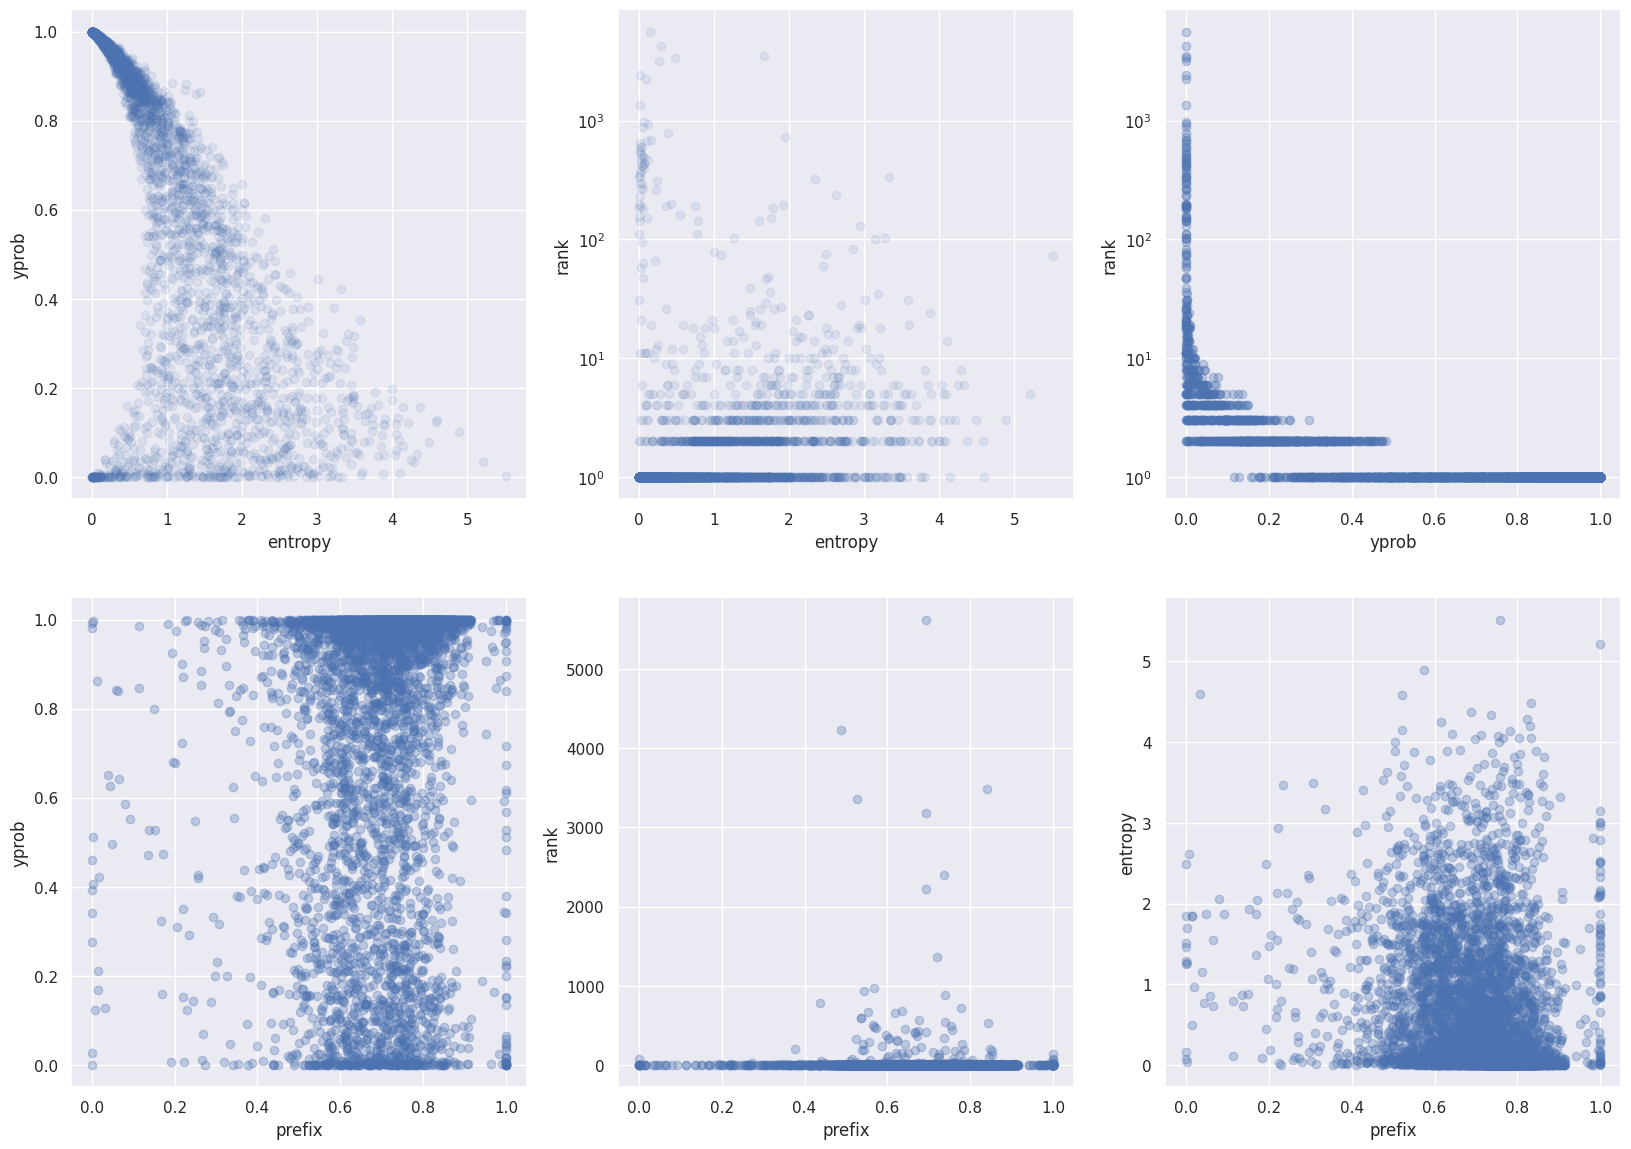

In [8]:
# ax[0][1].scatter(entropy_all, rank_all, alpha=0.1)
# ax[0][1].set_xlabel('entropy')
# ax[0][1].set_ylabel('rank')
# ax[0][1].set_yscale('log')

# ax[0][2].scatter(yprob_all, rank_all, alpha=0.3)
# ax[0][2].set_xlabel('yprob')
# ax[0][2].set_ylabel('rank')
# ax[0][2].set_yscale('log')

# ax[1][0].scatter(prefix_all, yprob_all, alpha=0.3)
# ax[1][0].set_xlabel('prefix')
# ax[1][0].set_ylabel('yprob')

# ax[1][1].scatter(prefix_all, rank_all, alpha=0.3)
# ax[1][1].set_xlabel('prefix')
# ax[1][1].set_ylabel('rank')

# ax[1][2].scatter(prefix_all, entropy_all, alpha=0.3)
# ax[1][2].set_xlabel('prefix')
# ax[1][2].set_ylabel('entropy')